<b>Bayesian Network:</b> A Bayesian Network consists of a directed graph and a conditional probability distribution associated with each of the random variables. A Bayesian network is used mostly when there is a causal relationship between the random variables.<br>
<br>
vs.<br>
<br>
<b>Markov Network:</b> A Markov Network consists of an undi- rected graph and a few Factors are associated with it. Unlike Conditional Probability Distributions, a Factor does not rep- resent the probabilities of variables in the network; instead it represents the compatibility between random variables that is how much a particular state of a random variable likely to agree with the another state of some other random variable.

A Bayesian Network consists of a directed graph where nodes represents random variables and edges represent the the relation between them. 
- It is parameterized using Conditional Probability Distributions (CPD). 
- Each random variable in a Bayesian Network has a CPD associated with it. 
- If a random varible has parents in the network then the CPD represents P(var|Parvar) i.e. the probability of that variable given its parents. 
- In the case, when the random variable has no parents it simply represents P(var) i.e. the probability of that variable.

https://conference.scipy.org/proceedings/scipy2015/pdfs/ankur_ankan.pdf

In [3]:
import pandas as pd
import numpy as np
from pgmpy.estimators import ConstraintBasedEstimator
from pgmpy.inference import VariableElimination
from sklearn.cross_validation import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/Users/nmolivo/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
data = pd.read_csv('../assets/04_model_data.csv')

In [10]:
data.head()

,Unnamed: 0,Type,Activity,Fatal (Y/N),ts_date,ts_year,geo_country,gmtoffset,phase,pop_lag,First Quarter,Full Moon,Last Quarter,New Moon
0,0,Unprovoked,Scuba Diving,N,11/30/17,2017,Costa Rica,-6,First Quarter,4857274.0,1,0,0,0
1,1,Unprovoked,Scuba diving,Y,11/30/17,2017,Costa Rica,-6,First Quarter,4857274.0,1,0,0,0
2,2,Sea Disaster,2 boats capsized,Y,11/25/17,2017,Libya,3,First Quarter,6293253.0,1,0,0,0
3,3,Sea Disaster,Air Disaster,Y,2/8/09,2009,United States,-4,Full Moon,304093966.0,0,1,0,0
4,4,Unprovoked,Treading water,N,8/16/08,2008,United States,-4,Full Moon,301231207.0,0,1,0,0


In [11]:
data = data.drop(['Unnamed: 0', 'New Moon', 'First Quarter', 'Last Quarter', 'Full Moon', 'Activity', 'gmtoffset'], axis =1)

print(len(data))
data.dropna(inplace=True)
print(len(data))

1227
1205


In [12]:
data.rename(columns={"Fatal (Y/N)": 'fatal', "ts_date": 'month', "ts_year": 'year'}, inplace=True)
data['month'] = data['month'].apply(lambda x: int(str(x).split('/')[0]))
data['fatal'] = data['fatal'].map({'N': 0, 'Y': 1})
data['phase'] = data['phase'].map({'New Moon': 0, 'First Quarter': 1, 'Full Moon': 3, 'Last Quarter': 4})
data['pop_lag'] = np.log(data['pop_lag'])
data.head()

,Type,fatal,month,year,geo_country,phase,pop_lag
0,Unprovoked,0.0,11,2017,Costa Rica,1,15.395988
1,Unprovoked,1.0,11,2017,Costa Rica,1,15.395988
2,Sea Disaster,1.0,11,2017,Libya,1,15.654989
3,Sea Disaster,1.0,2,2009,United States,3,19.532847
4,Unprovoked,0.0,8,2008,United States,3,19.523389


In [13]:
type_dummies = pd.get_dummies(data['Type'])
data = pd.concat([data, type_dummies], axis=1)
data.head()

,Type,fatal,month,year,geo_country,phase,pop_lag,Boat,Boating,Provoked,Sea Disaster,Unprovoked
0,Unprovoked,0.0,11,2017,Costa Rica,1,15.395988,0,0,0,0,1
1,Unprovoked,1.0,11,2017,Costa Rica,1,15.395988,0,0,0,0,1
2,Sea Disaster,1.0,11,2017,Libya,1,15.654989,0,0,0,1,0
3,Sea Disaster,1.0,2,2009,United States,3,19.532847,0,0,0,1,0
4,Unprovoked,0.0,8,2008,United States,3,19.523389,0,0,0,0,1


In [14]:
del data['Type']

In [15]:
# to sum a total count of attacks
data['attack'] = 1

# create a country-year-month dataset to have all the times where a shark attack didn't happen, too.
# pop_lag is the same in every month for each country-year
cym = pd.DataFrame(data.groupby(('geo_country', 'year', 'month', 'pop_lag')).sum()) 
cym.reset_index(inplace=True)

# sometimes a single month with have more than one phase, we'll keep the max phase
del cym['phase']
cym = cym.merge(data[['geo_country', 'year', 'month', 'phase']], on=['geo_country', 'year', 'month'], how='left')
cym.drop_duplicates(subset=['geo_country', 'year', 'month'], keep='last', inplace=True)
cym.head()

,geo_country,year,month,pop_lag,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,attack,phase
0,Aruba,2015,12,11.550173,1.0,0,0,0,0,1,1,1
2,Australia,2007,1,16.845543,0.0,0,0,0,0,2,2,4
3,Australia,2007,2,16.845543,0.0,0,0,0,0,1,1,3
5,Australia,2007,3,16.845543,0.0,0,0,0,0,2,2,4
7,Australia,2007,5,16.845543,0.0,0,0,0,0,2,2,0


In [16]:
# fill in the empty years
n_countries = cym['geo_country'].nunique()
n_years = cym['year'].nunique()
n_months = cym['month'].nunique()

In [17]:
countries = [c for country in list(cym['geo_country'].unique()) for c in [country]*(n_years*n_months)]
years = [y for year in sorted(list(cym['year'].unique()))*n_countries for y in [year]*n_months]
months = [m for m in sorted(list(cym['month'].unique()))*(n_countries*n_years)]

In [18]:
full_cym = pd.DataFrame(list(zip(countries, years, months)), columns=['geo_country', 'year', 'month'])

In [19]:
full_cym = full_cym.merge(cym, on=['geo_country', 'year', 'month'], how='left')
full_cym.head()

,geo_country,year,month,pop_lag,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,attack,phase
0,Aruba,2007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,2007,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,2007,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,2007,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,2007,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# linearly interpolate the population data
int_pop = pd.DataFrame(full_cym.groupby(['geo_country', 'year'])['pop_lag'].mean()).reset_index()
int_pop.head()

,geo_country,year,pop_lag
0,Aruba,2007,NaN
1,Aruba,2008,NaN
2,Aruba,2009,NaN
3,Aruba,2010,NaN
4,Aruba,2011,NaN


In [21]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html
int_pop = int_pop.groupby('geo_country').apply(lambda group: group.interpolate(method='linear', limit_direction='both', 
                                                                     limit=n_years))

In [22]:
full_cym = full_cym.merge(int_pop, on=['geo_country', 'year'], how='left')
full_cym.head()

,geo_country,year,month,pop_lag_x,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,attack,phase,pop_lag_y
0,Aruba,2007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173
1,Aruba,2007,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173
2,Aruba,2007,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173
3,Aruba,2007,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173
4,Aruba,2007,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173


In [23]:
del full_cym['pop_lag_x']
full_cym.rename(columns={'pop_lag_y': 'log_pop'}, inplace=True)
full_cym.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8712 entries, 0 to 8711
Data columns (total 12 columns):
geo_country     8712 non-null object
year            8712 non-null int64
month           8712 non-null int64
fatal           543 non-null float64
Boat            544 non-null float64
Boating         544 non-null float64
Provoked        544 non-null float64
Sea Disaster    544 non-null float64
Unprovoked      544 non-null float64
attack          544 non-null float64
phase           544 non-null float64
log_pop         8712 non-null float64
dtypes: float64(9), int64(2), object(1)
memory usage: 884.8+ KB


In [24]:
# fill everything else with 0s, because there was nothing that country-year-month
full_cym.fillna(0, inplace=True)

In [25]:
full_cym.head()

,geo_country,year,month,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,attack,phase,log_pop
0,Aruba,2007,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173
1,Aruba,2007,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173
2,Aruba,2007,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173
3,Aruba,2007,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173
4,Aruba,2007,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173


In [26]:
# turn the log of population into a discrete variable for use in the Bayesian network
full_cym['log_pop_cat'] = pd.cut(full_cym['log_pop'], 10, labels=range(10))
full_cym.head()

,geo_country,year,month,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,attack,phase,log_pop,log_pop_cat
0,Aruba,2007,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2
1,Aruba,2007,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2
2,Aruba,2007,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2
3,Aruba,2007,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2
4,Aruba,2007,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2


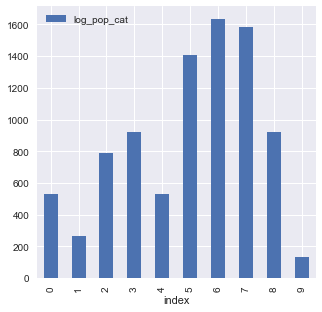

In [27]:
# do the bins look right? Yes they do.
pop_cat = pd.DataFrame(full_cym.log_pop_cat.value_counts())
pop_cat.reset_index(inplace=True)
pop_cat.sort_values(by='index', inplace=True)
pop_cat.plot(x='index', y='log_pop_cat', kind='bar', figsize=(5, 5))

In [28]:
del full_cym['log_pop']
full_cym.head()

,geo_country,year,month,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,attack,phase,log_pop_cat
0,Aruba,2007,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,Aruba,2007,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Aruba,2007,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Aruba,2007,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,Aruba,2007,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [29]:
full_cym.describe()

,year,month,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,attack,phase
count,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000
mean,2012.000000,6.500000,0.011134,0.001492,0.006543,0.012167,0.001148,0.116965,0.138315,0.129477
std,3.162459,3.452251,0.111306,0.041470,0.096207,0.120607,0.033862,0.698311,0.782539,0.638377
min,2007.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2009.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2012.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015.000000,9.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2017.000000,12.000000,2.000000,2.000000,3.000000,2.000000,1.000000,13.000000,15.000000,4.000000


<b>DAG (pattern) construction</b><br>
Given the set of conditional independencies in a probability distribution, we try to find a DAG for which the Markov condition entails all and only those conditional independencies (test for conditional independence using the Chi-squared test).

1. Construct an undirected skeleton - estimate_skeleton()
2. Orient compelled edges to obtain partially directed acyclid graph (PDAG; I-equivalence class of DAGs) - skeleton_to_pdag()
3. Extend DAG pattern to a DAG by conservatively orienting the remaining edges - pdag_to_dag()
    - Completes a PDAG to a DAG, without adding v-structures, if such a completion exists.
    - http://www.jmlr.org/papers/volume2/chickering02a/chickering02a.pdf

Step 1 and 2 form the so-called PC algorithm (page 550). PDAGs are DirectedGraphs, that may contain both-way edges, to indicate that the orientation for the edge is not determined.

http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks(Neapolitan,%20Richard).pdf

In [30]:
# construct the estimator

In [31]:
est = ConstraintBasedEstimator(full_cym)

In [32]:
# learn the structure of the network
skel, seperating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

Undirected edges:  [('Provoked', 'attack'), ('geo_country', 'log_pop_cat'), ('Unprovoked', 'attack'), ('attack', 'phase')]
PDAG edges:        [('Provoked', 'attack'), ('geo_country', 'log_pop_cat'), ('Unprovoked', 'attack'), ('attack', 'phase'), ('phase', 'attack'), ('log_pop_cat', 'geo_country')]
DAG edges:         [('Provoked', 'attack'), ('Unprovoked', 'attack'), ('attack', 'phase'), ('log_pop_cat', 'geo_country')]


In [33]:
# train the model to learn the conditional probability distributions
train_data, test_data = train_test_split(full_cym, test_size=0.05, random_state=0)
print(len(train_data))
print(len(test_data))

8276
436


In [34]:
# train the model and find the conditional probability distributions
%time model.fit(train_data)
model.get_cpds()

CPU times: user 140 ms, sys: 5.72 ms, total: 146 ms
Wall time: 170 ms


[<TabularCPD representing P(Boat:3) at 0x119c79278>,
 <TabularCPD representing P(Boating:4) at 0x11996c978>,
 <TabularCPD representing P(Provoked:3) at 0x11d351748>,
 <TabularCPD representing P(Sea Disaster:2) at 0x11d351208>,
 <TabularCPD representing P(Unprovoked:13) at 0x11d3515c0>,
 <TabularCPD representing P(attack:15 | Provoked:3, Unprovoked:13) at 0x119c79c88>,
 <TabularCPD representing P(fatal:3) at 0x119c792e8>,
 <TabularCPD representing P(geo_country:66 | log_pop_cat:10) at 0x119c79a90>,
 <TabularCPD representing P(log_pop_cat:10) at 0x11d43d198>,
 <TabularCPD representing P(month:12) at 0x11d43ddd8>,
 <TabularCPD representing P(phase:4 | attack:15) at 0x11d43d668>,
 <TabularCPD representing P(year:11) at 0x11d43d320>]

In [35]:
# test the model by predicting number of attacks
test_data_drop = test_data.drop('attack', axis=1)
%time preds = model.predict(test_data_drop)

CPU times: user 42 s, sys: 120 ms, total: 42.1 s
Wall time: 42.4 s


In [36]:
preds.sum()

attack    36.0
dtype: float64

In [38]:
test_data['predicted'] = preds
agree = sum(test_data['attack']==test_data['predicted'])
print('{} accuracy'.format(round(agree/len(test_data)*100), 3))

97.0 accuracy


In [35]:
# conduct inference on the model (prop of outcomes given evidence)
print('Variable Elimination')
ve = VariableElimination(model)
# unconditional probability of attack
print(ve.query(variables=['attack'])['attack'])

# conditional probability of attack given 1 Sea Disaster
print(ve.query(variables=['attack'], evidence={'Sea Disaster': 1})['attack'])

Variable Elimination
╒═══════════╤═══════════════╕
│ attack    │   phi(attack) │
╞═══════════╪═══════════════╡
│ attack_0  │        0.9323 │
├───────────┼───────────────┤
│ attack_1  │        0.0446 │
├───────────┼───────────────┤
│ attack_2  │        0.0079 │
├───────────┼───────────────┤
│ attack_3  │        0.0049 │
├───────────┼───────────────┤
│ attack_4  │        0.0026 │
├───────────┼───────────────┤
│ attack_5  │        0.0021 │
├───────────┼───────────────┤
│ attack_6  │        0.0017 │
├───────────┼───────────────┤
│ attack_7  │        0.0011 │
├───────────┼───────────────┤
│ attack_8  │        0.0008 │
├───────────┼───────────────┤
│ attack_9  │        0.0003 │
├───────────┼───────────────┤
│ attack_10 │        0.0003 │
├───────────┼───────────────┤
│ attack_11 │        0.0001 │
├───────────┼───────────────┤
│ attack_12 │        0.0003 │
├───────────┼───────────────┤
│ attack_13 │        0.0009 │
├───────────┼───────────────┤
│ attack_14 │        0.0001 │
╘═══════════╧══════

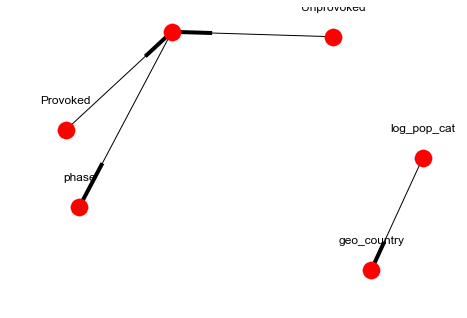

In [42]:
# graph the network
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
G.add_edges_from(model.edges())

pos = nx.spring_layout(G)
nx.draw(G, pos)
for k, v in pos.items():
    pos[k][1] += 0.1
nx.draw_networkx_labels(G, pos)

plt.show()

## Bayseian Network of Shark Attacks per Country-Year-Month

In [37]:
print(ve.query(variables=['attack'], evidence={'Provoked': 1})['attack'])

╒═══════════╤═══════════════╕
│ attack    │   phi(attack) │
╞═══════════╪═══════════════╡
│ attack_0  │        0.0000 │
├───────────┼───────────────┤
│ attack_1  │        0.9233 │
├───────────┼───────────────┤
│ attack_2  │        0.0535 │
├───────────┼───────────────┤
│ attack_3  │        0.0065 │
├───────────┼───────────────┤
│ attack_4  │        0.0069 │
├───────────┼───────────────┤
│ attack_5  │        0.0042 │
├───────────┼───────────────┤
│ attack_6  │        0.0014 │
├───────────┼───────────────┤
│ attack_7  │        0.0000 │
├───────────┼───────────────┤
│ attack_8  │        0.0023 │
├───────────┼───────────────┤
│ attack_9  │        0.0008 │
├───────────┼───────────────┤
│ attack_10 │        0.0003 │
├───────────┼───────────────┤
│ attack_11 │        0.0008 │
├───────────┼───────────────┤
│ attack_12 │        0.0000 │
├───────────┼───────────────┤
│ attack_13 │        0.0000 │
├───────────┼───────────────┤
│ attack_14 │        0.0000 │
╘═══════════╧═══════════════╛


In [38]:
# conditional probability of provoked attack, given an unprovoked attack
print(ve.query(variables=['Provoked'], evidence={'Unprovoked': 1})['Provoked'])

╒════════════╤═════════════════╕
│ Provoked   │   phi(Provoked) │
╞════════════╪═════════════════╡
│ Provoked_0 │          0.9890 │
├────────────┼─────────────────┤
│ Provoked_1 │          0.0098 │
├────────────┼─────────────────┤
│ Provoked_2 │          0.0012 │
╘════════════╧═════════════════╛


In [39]:
# compared to the straight probability for a prokoked attack, we see that when there was an unprovoked attack it is
# also more likely that there was a provoked attack
print(ve.query(variables=['Provoked'])['Provoked'])

╒════════════╤═════════════════╕
│ Provoked   │   phi(Provoked) │
╞════════════╪═════════════════╡
│ Provoked_0 │          0.9890 │
├────────────┼─────────────────┤
│ Provoked_1 │          0.0098 │
├────────────┼─────────────────┤
│ Provoked_2 │          0.0012 │
╘════════════╧═════════════════╛


In [45]:
np.where(train_data['geo_country'].unique()=='United States')

(array([10]),)

In [51]:
# given that you're minding your own business, what happens to attacks
print(ve.query(variables=['attack'], evidence={'geo_country': 10})['attack'])

╒═══════════╤═══════════════╕
│ attack    │   phi(attack) │
╞═══════════╪═══════════════╡
│ attack_0  │        0.9323 │
├───────────┼───────────────┤
│ attack_1  │        0.0446 │
├───────────┼───────────────┤
│ attack_2  │        0.0079 │
├───────────┼───────────────┤
│ attack_3  │        0.0049 │
├───────────┼───────────────┤
│ attack_4  │        0.0026 │
├───────────┼───────────────┤
│ attack_5  │        0.0021 │
├───────────┼───────────────┤
│ attack_6  │        0.0017 │
├───────────┼───────────────┤
│ attack_7  │        0.0011 │
├───────────┼───────────────┤
│ attack_8  │        0.0008 │
├───────────┼───────────────┤
│ attack_9  │        0.0003 │
├───────────┼───────────────┤
│ attack_10 │        0.0003 │
├───────────┼───────────────┤
│ attack_11 │        0.0001 │
├───────────┼───────────────┤
│ attack_12 │        0.0003 │
├───────────┼───────────────┤
│ attack_13 │        0.0009 │
├───────────┼───────────────┤
│ attack_14 │        0.0001 │
╘═══════════╧═══════════════╛


In [41]:
print(ve.query(variables=['Unprovoked'])['Unprovoked'])

╒═══════════════╤═══════════════════╕
│ Unprovoked    │   phi(Unprovoked) │
╞═══════════════╪═══════════════════╡
│ Unprovoked_0  │            0.9457 │
├───────────────┼───────────────────┤
│ Unprovoked_1  │            0.0337 │
├───────────────┼───────────────────┤
│ Unprovoked_2  │            0.0072 │
├───────────────┼───────────────────┤
│ Unprovoked_3  │            0.0048 │
├───────────────┼───────────────────┤
│ Unprovoked_4  │            0.0025 │
├───────────────┼───────────────────┤
│ Unprovoked_5  │            0.0013 │
├───────────────┼───────────────────┤
│ Unprovoked_6  │            0.0016 │
├───────────────┼───────────────────┤
│ Unprovoked_7  │            0.0007 │
├───────────────┼───────────────────┤
│ Unprovoked_8  │            0.0007 │
├───────────────┼───────────────────┤
│ Unprovoked_9  │            0.0005 │
├───────────────┼───────────────────┤
│ Unprovoked_10 │            0.0005 │
├───────────────┼───────────────────┤
│ Unprovoked_11 │            0.0002 │
├───────────